In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image 

In [2]:
# Object points in 3D
GRID_SHAPE = (9,6)
objp = np.zeros((GRID_SHAPE[0]*GRID_SHAPE[1],3), np.float32)
objp[:,:2] = np.mgrid[0:GRID_SHAPE[0], 0:GRID_SHAPE[1]].T.reshape(-1,2)
objp *= 20 # One square on my grid has 20mm

In [3]:
folder_right = "calib_images/right/"
folder_left = "calib_images/left/"

In [4]:
# Load parameters
(K_l, K_r, dist_l, dist_r) = np.load("K_l.npy"), np.load("K_r.npy"), np.load("dist_coeff_l.npy"), np.load("dist_coeff_r.npy")

## Stereo

In [10]:
obj_pts = []
img_pts_l, img_pts_r = [], []

for fname_l, fname_r in zip(sorted(os.listdir(folder_left)), sorted(os.listdir(folder_right))):

    print(f"processing {fname_l, fname_r}")
    img_l, img_r = Image.open(folder_left + fname_l), Image.open(folder_right + fname_r)
    arr_l, arr_r = np.array(img_l), np.array(img_r)
    gray_l, gray_r  = arr_l, arr_r # the images are already grayscale so no conversion

    flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK
    ret_l, corners_l = cv2.findChessboardCorners(gray_l, GRID_SHAPE, flags)
    ret_r, corners_r = cv2.findChessboardCorners(gray_r, GRID_SHAPE, flags)

    if ret_l and ret_r:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners_subpix_l = cv2.cornerSubPix(gray_l, corners_l, (11,11), (-1,-1), criteria)
        corners_subpix_r = cv2.cornerSubPix(gray_r, corners_r, (11,11), (-1,-1), criteria)

        obj_pts.append(objp)
        img_pts_l.append(corners_subpix_l)
        img_pts_r.append(corners_subpix_r)

processing ('001.png', '001.png')
processing ('002.png', '002.png')
processing ('003.png', '003.png')
processing ('004.png', '004.png')
processing ('005.png', '005.png')
processing ('006.png', '006.png')
processing ('007.png', '007.png')


In [11]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC

criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retS, K_l, dist_l, K_r, dist_r, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(
    obj_pts,
    img_pts_l,
    img_pts_r,
    K_l, dist_l,
    K_r, dist_r,
    gray_l.shape[::-1],
    criteria_stereo,
    flags)

In [12]:
rect_l, rect_r, proj_mat_l, proj_mat_r, Q, roiL, roiR = cv2.stereoRectify(K_l, dist_l, K_r, dist_r, gray_l.shape[::-1], Rot, Trns, 1 ,(0,0))

In [13]:
left_stereo_maps = cv2.initUndistortRectifyMap(K_l, dist_l, rect_l, proj_mat_l,
                                             gray_l.shape[::-1], cv2.CV_16SC2)
right_stereo_maps = cv2.initUndistortRectifyMap(K_r, dist_r, rect_r, proj_mat_r,
                                              gray_l.shape[::-1], cv2.CV_16SC2)

In [14]:
arr_l_rect = cv2.remap(arr_l, left_stereo_maps[0],left_stereo_maps[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
arr_r_rect = cv2.remap(arr_r, right_stereo_maps[0],right_stereo_maps[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

Images L: 001.png, R: 001.png


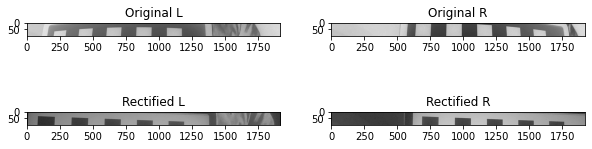

Images L: 002.png, R: 002.png


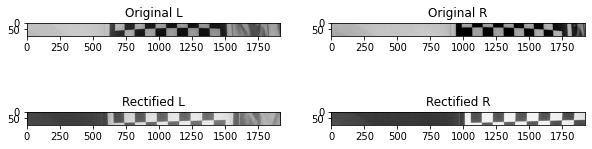

Images L: 003.png, R: 003.png


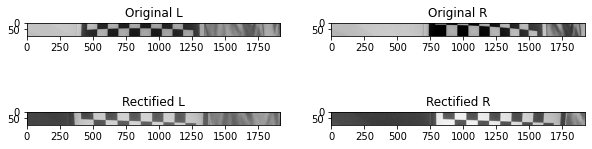

Images L: 004.png, R: 004.png


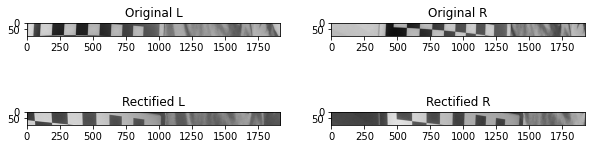

Images L: 005.png, R: 005.png


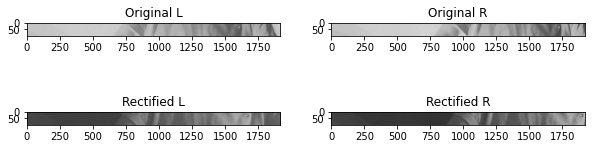

Images L: 006.png, R: 006.png


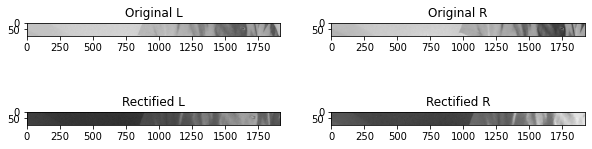

Images L: 007.png, R: 007.png


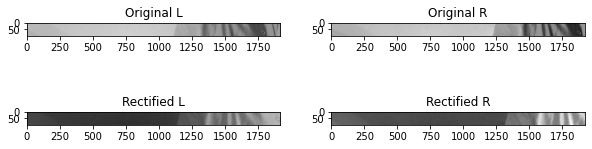

In [15]:
for fname_l, fname_r in zip(sorted(os.listdir(folder_left)), sorted(os.listdir(folder_right))):
    
    print(f"Images L: {fname_l}, R: {fname_r}")

    img_l, img_r = Image.open(folder_left + fname_l), Image.open(folder_right + fname_r)
    arr_l, arr_r = np.array(img_l), np.array(img_r)
    
    arr_l_rect = cv2.remap(arr_l, left_stereo_maps[0],left_stereo_maps[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    arr_r_rect = cv2.remap(arr_r, right_stereo_maps[0],right_stereo_maps[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(10,3))
    
    # before
    ax1.imshow(arr_l[100:200,:], cmap='binary')
    ax2.imshow(arr_r[100:200,:], cmap='binary')
    
    ax1.title.set_text('Original L')
    ax2.title.set_text('Original R')

    
    # after
    ax3.imshow(arr_l_rect[100:200,:], cmap='gray')
    ax4.imshow(arr_r_rect[100:200,:], cmap='gray')
    
    ax3.title.set_text('Rectified L')
    ax4.title.set_text('Rectified R')
    plt.show()

### Save undistort+recity map

In [16]:
cv_file = cv2.FileStorage("rectify_map_imx219_160deg_1080p_new.yaml", cv2.FILE_STORAGE_WRITE)
cv_file.write("map_l_1", left_stereo_maps[0])
cv_file.write("map_l_2", left_stereo_maps[1])
cv_file.write("map_r_1", right_stereo_maps[0])
cv_file.write("map_r_2", right_stereo_maps[1])
cv_file.release() 